<a href="https://colab.research.google.com/github/ctorney/abc-collective-movement/blob/main/two_parameter_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#zonal model inference with linear regression on summary stats
import os, sys
import numpy as np
from getpass import getpass
from math import *
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_palette("muted")

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 


from tqdm import tqdm
import scipy
%matplotlib inline
import matplotlib.ticker as ticker





sys.path.append('..')
sys.path.append('../inference_2d')

from gnn_model import model

from simulations import zonal_gnn
from simulations import zonal
from gpabc import gp_abc
from gpabc import am_sampler

from scipy.stats import gaussian_kde

import pickle

from params2d import *


import tensorflow as tf

In [23]:
gnn_model = tf.keras.models.load_model('../inference_2d/gnn/gnn_model')


data_sim = zonal_gnn.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=data_repeat, dt=dt,save_interval=save_interval,disable_progress=False)

latt= 9
lali= 5



data_sim.run_sim(lrep, lali, latt, va)


data_sum_stats = []

for i in range(data_repeat):

    X = data_sim.micro_state[i,:,:,:2]
    V = data_sim.micro_state[i,:,:,2:4]
    A = data_sim.micro_state[i,:,:,4:]
    
    
    data_sum_stats.append(gnn_model(model.parse_graph([X,V,A])[0]).numpy())#[:,1:3])


macrodata = np.array(data_sum_stats).reshape((-1,ndim))
        
        
        
data_vector = np.mean(macrodata,axis=0) 
sd0 =  np.std(macrodata,axis=0) 
cov = np.diag(sd0**2)
def abc_likelihood_2d(sim_output):
    repeat = sim_output.shape[0]
    k = sim_output.shape[1]

    return np.log(1e-18 + 1/repeat *  (((2*pi)**k)**0.5*np.product(sd0))*np.sum(scipy.stats.multivariate_normal(data_vector,cov).pdf(sim_output)))

    #return np.log(1e-18 + 1/repeat * (((2*pi*np.product(sd0))**k)**0.5)*np.sum(scipy.stats.multivariate_normal(data_vector,cov).pdf(sim_output)))




def simulator_2d(params):


    sim = zonal_gnn.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=sim_repeat, dt=dt,save_interval=1,disable_progress=True, save_micro=False)


    sim.run_sim(lrep, params[0], params[1], va)


    sum_stats = []


    for i in range(sim_repeat):

        X = sim.micro_state[i,:,:,:2]
        V = sim.micro_state[i,:,:,2:4]
        A = sim.micro_state[i,:,:,4:]


        sum_stats.append(gnn_model(model.parse_graph([X,V,A])[0]).numpy())#[:,1:3])

    return np.array(sum_stats).reshape((-1,ndim))    

# use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
plotwaves = [0,3,6,9]
gnn_waves = []

abcGP = gp_abc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d) 


for i in range(n_wave):
    abcGP.runWave()     
    abcGP.remove_implausible()
    if (i in plotwaves): 
        xx, yy = np.meshgrid(X[0], X[1], sparse=False)
        x_grid = np.array([xx.flatten(), yy.flatten()]).T
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
        y_pred = y_pred.reshape(100,100)
        gnn_waves.append(y_pred.copy())
    
    

100%|██████████| 2001/2001 [00:03<00:00, 603.02it/s]
25it [09:28, 22.74s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
44it [09:30, 12.97s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
56it [09:29, 10.16s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
79it [09:34,  7.28s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
100it [09:33,  5.73s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
123it [09:38,  4.71s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
145it [09:35,  3.97s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.leng

In [24]:


simulation_cls = zonal.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=data_repeat, dt=dt,save_interval=save_interval)
            
simulation_cls.run_sim(lrep, lali, latt, va)

data_va=va
data_latt=latt
data_lali=lali
data_lrep=lrep

op, rot, nnd = simulation_cls.get_macro_states()
macrodata=  np.array([op[:,-1], rot[:,-1],nnd[:,-1]])

def abc_likelihood_2d(sim_output,rc=None):
    theta_0 = sim_output

    ss_0 = macrodata
    theta_DATA0 = np.mean(ss_0,axis=-1) 
    sd0 =  np.std(ss_0,axis=-1) 
    cov = np.diag(sd0**2)
    repeat = sim_output.shape[1]

    k = sd0.shape[0]
    return np.log(1e-18 + 1/repeat * (((2*pi*np.product(sd0))**k)**0.5)*np.sum(scipy.stats.multivariate_normal(theta_DATA0,cov).pdf(theta_0.T)))


def simulator_2d(params):
    simulation_cls = zonal.zonal_model(N,timesteps+discard,discard=discard,repeat=sim_repeat,L=L,dt=dt, save_interval=1,disable_progress=True) 

    simulation_cls.run_sim(lrep, params[0], params[1], va)

    output = np.array(simulation_cls.get_macro_states()) 

    return output 


        # use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
plotwaves = [0,3,6,9]
ss_waves = []

abcGP = gp_abc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d) 



for i in range(n_wave):
    abcGP.runWave()     
    abcGP.remove_implausible()
    if (i in plotwaves): 
        xx, yy = np.meshgrid(X[0], X[1], sparse=False)
        x_grid = np.array([xx.flatten(), yy.flatten()]).T
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
        y_pred = y_pred.reshape(100,100)
        ss_waves.append(y_pred.copy())
    
    

100%|██████████| 2001/2001 [00:05<00:00, 398.30it/s]
25it [04:38, 11.13s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
37it [04:36,  7.48s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
55it [04:36,  5.02s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
69it [04:36,  4.01s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
87it [04:36,  3.18s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
106it [04:36,  2.61s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
127it [04:38,  2.19s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengt

In [25]:
from gpabc import gp_abc_rc

simulation_cls = zonal.zonal_model(N,timesteps=timesteps+discard,discard=discard,L=L,repeat=data_repeat, dt=dt,save_interval=save_interval)

simulation_cls.run_sim(lrep, lali, latt, va)

data_va=va
data_latt=latt
data_lali=lali
data_lrep=lrep

op, rot, nnd = simulation_cls.get_macro_states()
macrodata=  np.array([op[:,-1], rot[:,-1],nnd[:,-1]])


def abc_likelihood_2d(sim_output,rc):
    theta_0 = rc@sim_output

    ss_0 = rc@macrodata
    theta_DATA0 = np.mean(ss_0,axis=-1) 
    sd0 =  np.std(ss_0,axis=-1) 
    cov = np.diag(sd0**2)
    repeat = sim_output.shape[1]

    k = sd0.shape[0]
    #return np.log(1e-18 + 1/repeat * (((2*pi*np.product(sd0))**k)**0.5)*np.sum(scipy.stats.multivariate_normal(theta_DATA0,cov).pdf(theta_0.T)))
    return np.log(1e-18 + 1/repeat * (((2*pi)**k)**0.5*np.product(sd0))*np.sum(scipy.stats.multivariate_normal(theta_DATA0,cov).pdf(theta_0.T)))


def simulator_2d(params):
    simulation_cls = zonal.zonal_model(N,timesteps+discard,discard=discard,repeat=sim_repeat,L=L,dt=dt, save_interval=1,disable_progress=True) 
    simulation_cls.run_sim(lrep, params[0], params[1], va)
    output = np.array(simulation_cls.get_macro_states()) 
    return output[...,-1] 




        # use values for plotting the predicted GP
X = np.array([np.linspace(p_start[0],p_start[0]+p_range[0],100),np.linspace(p_start[1],p_start[1]+p_range[1],100)])
plotwaves = [0,3,6,9]
rc_waves = []

abcGP = gp_abc_rc.abcGP(p_start,p_range,ndim,n_points,T,simulator_2d,abc_likelihood_2d) 


for i in range(n_wave):
    abcGP.runWave()     
    abcGP.remove_implausible()
    if (i in plotwaves): 
        xx, yy = np.meshgrid(X[0], X[1], sparse=False)
        x_grid = np.array([xx.flatten(), yy.flatten()]).T
        y_pred, y_std  = abcGP.predict_final(x_grid,remove_implausible=True)
        y_pred = y_pred.reshape(100,100)
        rc_waves.append(y_pred.copy())
    


100%|██████████| 2001/2001 [00:04<00:00, 483.01it/s]
25it [04:36, 11.05s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
39it [04:35,  7.06s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
54it [04:36,  5.12s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
63it [04:35,  4.37s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
88it [04:35,  3.13s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
113it [04:35,  2.44s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale
134it [04:37,  2.07s/it]
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengt

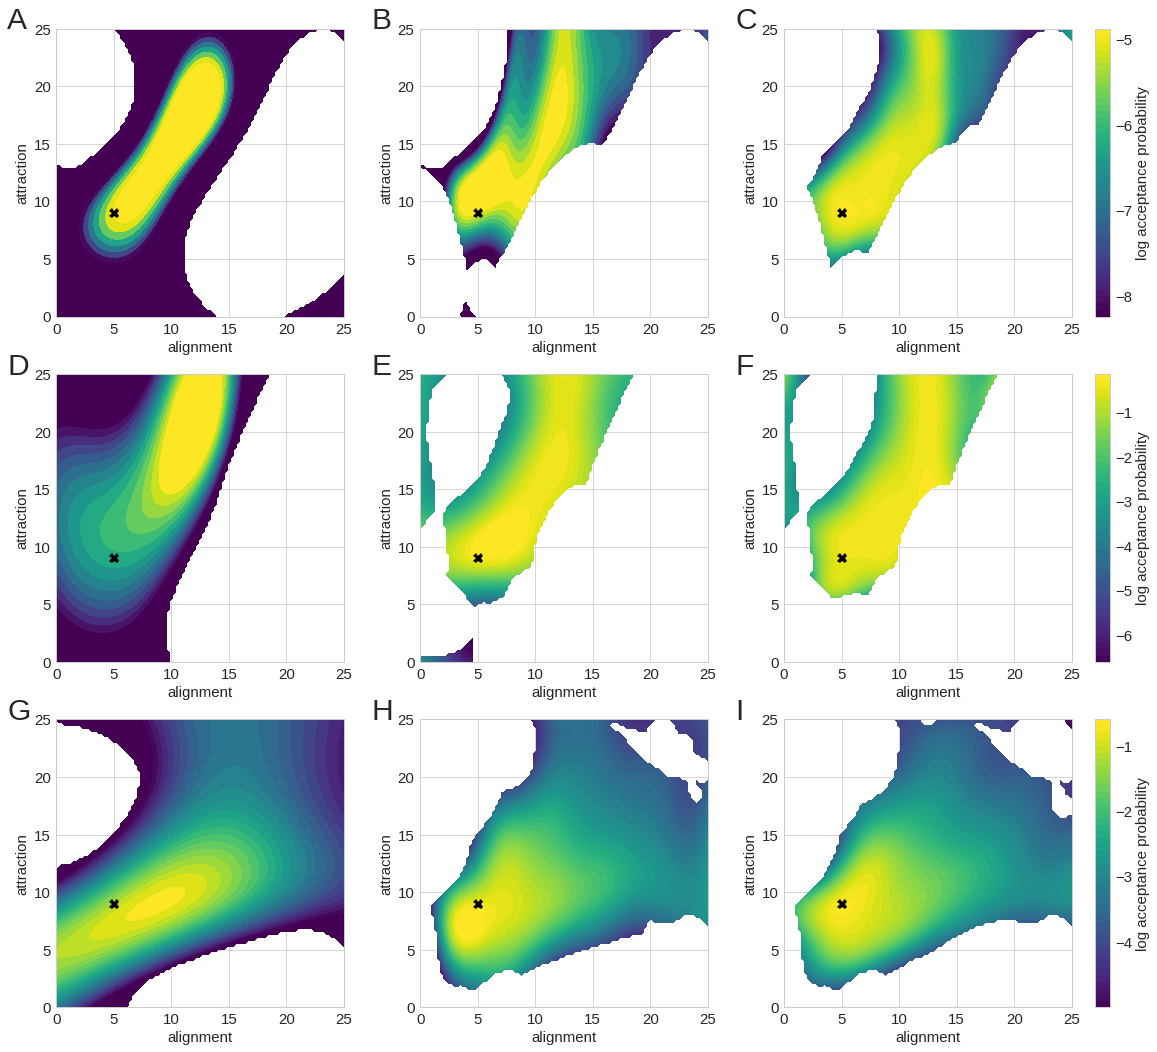

In [126]:
fig, ax = plt.subplots(3, 3, figsize=(21,18))

row_data = [ss_waves,rc_waves,gnn_waves]
labels = [["A","B","C"],["D","E","F"],["G","H","I"]]
for row in range(3):
    
    wave_data = row_data[row]
    
    grid = wave_data[2]
    vmin = grid[np.isfinite(grid)].min()
    vmax = grid[np.isfinite(grid)].max()
    for wave in range(3):
        axc = ax[row,wave]
        axc.plot(lali,latt,'X',c='k',markersize=10) 
        h = axc.contourf(X[0], X[1], wave_data[wave],50,cmap='viridis',vmin=vmin,vmax=vmax)  #0.1*
        axc.text(-0.17,1,labels[row][wave], size=30, transform=axc.transAxes)

        axc.set_ylabel('attraction',size=15)
        axc.set_xlabel('alignment',size=15)
        axc.tick_params(axis='both', which='major', labelsize=15)
        
        axc.set_xlim(0,25)
        axc.set_ylim(0,25)
        #axc.axis('equal')
        axc.set_aspect('equal', adjustable='box')

    ticks = np.arange(ceil(vmin),ceil(vmax))

    cb = fig.colorbar(h, ax=ax[row],shrink=1.0,ticks=ticks,fraction=0.10,pad=0.02)
    cb.ax.tick_params(labelsize=15)
    cb.ax.set_ylabel('log acceptance probability',size=15)


plt.savefig('../publication_images/2d_surfaces_plots.png',dpi=300,bbox_inches='tight')
plt.show()
